# Lag Feature 효과 테스트 (v4 데이터셋)

## 변경사항
- **v3**: prophet_forecast 컬럼에 모든 카테고리 예측값이 동일하게 들어감
- **v4**: prophet_forecast × category 비율 적용 → 해당 책의 카테고리 가중 예측값

## 분석 목적
- category × prophet_forecast 가중치 적용 후 예측력 변화 확인
- y_lag1 대비 prophet_forecast의 기여도 재평가

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, r2_score, mean_absolute_error,
                             precision_score, recall_score)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
import lightgbm as lgb
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 이미지 저장 경로
IMG_PATH = 'ml_image_v4'
os.makedirs(IMG_PATH, exist_ok=True)

## 1. 데이터 로드 및 Lag 피처 생성

In [2]:
df = pd.read_csv('books_ml_dataset_v4.csv')
df['ymw'] = df['ymw'].astype(str)
df = df.sort_values(['product_code', 'ymw']).reset_index(drop=True)

# Lag 피처 생성 (책별로)
for lag in [1, 2, 3, 4]:
    df[f'y_lag{lag}'] = df.groupby('product_code')['y_sales_score'].shift(lag)

print(f'원본 데이터: {len(df):,}개')
print(f'\n[Lag 피처 결측치]')
for lag in [1, 2, 3, 4]:
    na = df[f'y_lag{lag}'].isna().sum()
    print(f'y_lag{lag}: {na}개 ({na/len(df)*100:.1f}%)')

# 결측치 제거
df_lag = df.dropna(subset=['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4']).reset_index(drop=True)
print(f'\n결측치 제거 후: {len(df_lag):,}개')

원본 데이터: 7,191개

[Lag 피처 결측치]
y_lag1: 141개 (2.0%)
y_lag2: 282개 (3.9%)
y_lag3: 423개 (5.9%)
y_lag4: 564개 (7.8%)

결측치 제거 후: 6,627개


## 2. 피처 정의

In [3]:
# 피처 정의
feature_cols = [c for c in df_lag.columns if c not in ['product_code', 'ymw', 'y_sales_score'] and not c.startswith('y_lag')]

print(f'기존 피처 수: {len(feature_cols)}개')
print(f'\n[피처 목록]')
for i, col in enumerate(feature_cols):
    print(f'  {i+1}. {col}')

기존 피처 수: 43개

[피처 목록]
  1. category_1
  2. category_2
  3. category_3
  4. category_4
  5. category_5
  6. category_6
  7. category_7
  8. category_8
  9. category_9
  10. category_10
  11. category_1_x_viral_index
  12. category_2_x_viral_index
  13. category_3_x_viral_index
  14. category_4_x_viral_index
  15. category_5_x_viral_index
  16. category_6_x_viral_index
  17. category_7_x_viral_index
  18. category_8_x_viral_index
  19. category_9_x_viral_index
  20. category_10_x_viral_index
  21. prophet_forecast_macro_economy
  22. prophet_forecast_econ_theory
  23. prophet_forecast_financial_crisis
  24. prophet_forecast_business
  25. prophet_forecast_real_estate
  26. prophet_forecast_personal_finance
  27. prophet_forecast_stock_trading
  28. prophet_forecast_geopolitics
  29. prophet_forecast_tech_startup
  30. prophet_forecast_invest_philosophy
  31. kospi
  32. usd_krw
  33. brent_oil
  34. resd_business
  35. resd_econ_theory
  36. resd_financial_crisis
  37. resd_geopolitics
 

## 3. 상관관계 분석

In [4]:
y = df_lag['y_sales_score']

print('[Lag 피처 vs 타겟 상관관계]')
print(f'{"피처":<12} {"r":<10} {"해석"}')
print('-'*35)
for lag in [1, 2, 3, 4]:
    corr, _ = stats.pearsonr(df_lag[f'y_lag{lag}'], y)
    print(f'y_lag{lag:<7} {corr:<10.4f} {"강함" if corr > 0.5 else "중간"}')

# 기존 피처 상관관계 Top 10
print(f'\n[기존 피처 상관관계 Top 10]')
corr_list = []
for col in feature_cols:
    corr, _ = stats.pearsonr(df_lag[col], y)
    corr_list.append((col, corr))
corr_list.sort(key=lambda x: abs(x[1]), reverse=True)

for col, corr in corr_list[:10]:
    print(f'  {col:<45} r = {corr:.4f}')

[Lag 피처 vs 타겟 상관관계]
피처           r          해석
-----------------------------------
y_lag1       0.8850     강함
y_lag2       0.7759     강함
y_lag3       0.6677     강함
y_lag4       0.5648     강함

[기존 피처 상관관계 Top 10]
  category_10                                   r = 0.0935
  category_4                                    r = -0.0910
  prophet_forecast_business                     r = -0.0768
  prophet_forecast_invest_philosophy            r = 0.0760
  category_3                                    r = 0.0593
  category_5                                    r = -0.0590
  prophet_forecast_financial_crisis             r = 0.0442
  prophet_forecast_econ_theory                  r = 0.0427
  prophet_forecast_tech_startup                 r = -0.0403
  category_9                                    r = -0.0383


## 4. Train/Test Split (Random + Time-based)

In [5]:
# 피처셋 정의
all_features = feature_cols + ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4']
X = df_lag[all_features]
y = df_lag['y_sales_score']
y_class = (y > 0).astype(int)

# Random Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_class, y_test_class = (y_train > 0).astype(int), (y_test > 0).astype(int)

# Time-based Split
df_lag_sorted = df_lag.sort_values('ymw').reset_index(drop=True)
split_idx = int(len(df_lag_sorted) * 0.8)
train_time = df_lag_sorted.iloc[:split_idx]
test_time = df_lag_sorted.iloc[split_idx:]

X_train_time = train_time[all_features]
X_test_time = test_time[all_features]
y_train_time = train_time['y_sales_score']
y_test_time = test_time['y_sales_score']
y_train_time_class = (y_train_time > 0).astype(int)
y_test_time_class = (y_test_time > 0).astype(int)

print('[Random Split]')
print(f'  Train: {len(X_train):,}개, Test: {len(X_test):,}개')
print(f'\n[Time-based Split]')
print(f'  Train: {train_time["ymw"].min()} ~ {train_time["ymw"].max()} ({len(train_time):,}개)')
print(f'  Test:  {test_time["ymw"].min()} ~ {test_time["ymw"].max()} ({len(test_time):,}개)')

[Random Split]
  Train: 5,301개, Test: 1,326개

[Time-based Split]
  Train: 2025022 ~ 2025104 (5,301개)
  Test:  2025104 ~ 2025124 (1,326개)


## 5. 피처셋별 성능 비교 (LightGBM)

In [6]:
feature_sets = {
    '기존 피처만': feature_cols,
    '기존 + y_lag1': feature_cols + ['y_lag1'],
    '기존 + y_lag1~4': feature_cols + ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4'],
    'y_lag만 (1~4)': ['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4'],
    'y_lag1만': ['y_lag1'],
}

results_random = []
results_time = []

print('[Random Split 결과]')
print(f'{"피처셋":<22} {"R2":<10} {"MAE":<10} {"F1":<10} {"AUC":<10}')
print('-'*62)

for name, features in feature_sets.items():
    # 회귀
    reg = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg.fit(X_train[features], y_train)
    y_pred = np.maximum(reg.predict(X_test[features]), 0)
    
    # 분류
    clf = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
    clf.fit(X_train[features], y_train_class)
    y_prob = clf.predict_proba(X_test[features])[:, 1]
    y_pred_c = clf.predict(X_test[features])
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    f1 = f1_score(y_test_class, y_pred_c)
    auc = roc_auc_score(y_test_class, y_prob)
    
    results_random.append({'name': name, 'r2': r2, 'mae': mae, 'f1': f1, 'auc': auc})
    print(f'{name:<22} {r2:<10.4f} {mae:<10.4f} {f1:<10.4f} {auc:<10.4f}')

[Random Split 결과]
피처셋                    R2         MAE        F1         AUC       
--------------------------------------------------------------


기존 피처만                 0.4008     1.7009     0.6873     0.8778    


기존 + y_lag1            0.6941     0.7560     0.9432     0.9470    


기존 + y_lag1~4          0.6983     0.7361     0.9432     0.9456    


y_lag만 (1~4)           0.6905     0.7722     0.9490     0.9544    


y_lag1만                0.7009     0.7383     0.9490     0.9513    


In [7]:
print('[Time-based Split 결과]')
print(f'{"피처셋":<22} {"R2":<10} {"MAE":<10} {"F1":<10} {"AUC":<10}')
print('-'*62)

for name, features in feature_sets.items():
    # 회귀
    reg = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg.fit(X_train_time[features], y_train_time)
    y_pred = np.maximum(reg.predict(X_test_time[features]), 0)
    
    # 분류
    clf = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42, verbose=-1)
    clf.fit(X_train_time[features], y_train_time_class)
    y_prob = clf.predict_proba(X_test_time[features])[:, 1]
    y_pred_c = clf.predict(X_test_time[features])
    
    r2 = r2_score(y_test_time, y_pred)
    mae = mean_absolute_error(y_test_time, y_pred)
    f1 = f1_score(y_test_time_class, y_pred_c)
    auc = roc_auc_score(y_test_time_class, y_prob)
    
    results_time.append({'name': name, 'r2': r2, 'mae': mae, 'f1': f1, 'auc': auc})
    print(f'{name:<22} {r2:<10.4f} {mae:<10.4f} {f1:<10.4f} {auc:<10.4f}')

[Time-based Split 결과]
피처셋                    R2         MAE        F1         AUC       
--------------------------------------------------------------


기존 피처만                 0.2232     2.0252     0.3779     0.6087    


기존 + y_lag1            0.8675     0.7136     0.9765     0.9797    


기존 + y_lag1~4          0.8736     0.6577     0.9765     0.9776    


y_lag만 (1~4)           0.8896     0.5595     0.9765     0.9787    


y_lag1만                0.8922     0.5553     0.9765     0.9774    


## 6. SHAP Values 분석

In [8]:
# LightGBM 모델 (기존 + y_lag1) - SHAP 분석
features_for_shap = feature_cols + ['y_lag1']
reg_shap = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
reg_shap.fit(X_train[features_for_shap], y_train)

# SHAP Explainer
explainer = shap.TreeExplainer(reg_shap)
shap_values = explainer.shap_values(X_test[features_for_shap])

print('[SHAP Values 분석 완료]')
print(f'  피처 수: {len(features_for_shap)}')
print(f'  테스트 샘플 수: {len(X_test)}')

[SHAP Values 분석 완료]
  피처 수: 44
  테스트 샘플 수: 1326


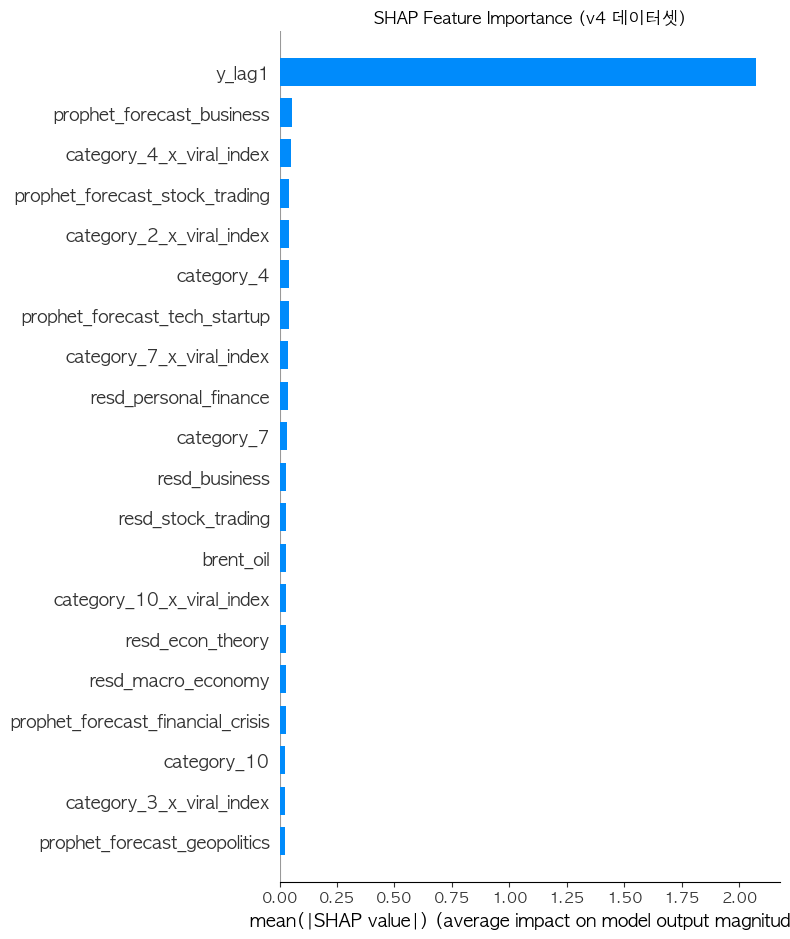

저장: ml_image_v4/shap_feature_importance_bar.png


In [9]:
# SHAP Summary Plot (Bar)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test[features_for_shap], plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance (v4 데이터셋)')
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/shap_feature_importance_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'저장: {IMG_PATH}/shap_feature_importance_bar.png')

In [10]:
# SHAP Top 10 Feature Importance 테이블
shap_importance = pd.DataFrame({
    'feature': features_for_shap,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)

print('[SHAP Feature Importance Top 15]')
print('='*55)
print(f'{"순위":<6}{"피처":<40}{"평균|SHAP|":<12}')
print('-'*55)
for i, (idx, row) in enumerate(shap_importance.head(15).iterrows()):
    print(f'{i+1:<6}{row["feature"]:<40}{row["mean_abs_shap"]:<12.4f}')

# y_lag1 vs prophet_forecast 비교
y_lag1_imp = shap_importance[shap_importance['feature'] == 'y_lag1']['mean_abs_shap'].values[0]
prophet_imp = shap_importance[shap_importance['feature'].str.startswith('prophet_forecast')]['mean_abs_shap'].sum()
total_imp = shap_importance['mean_abs_shap'].sum()

print(f'\n[중요도 비율]')
print(f'  y_lag1: {y_lag1_imp/total_imp*100:.1f}%')
print(f'  prophet_forecast (10개 합): {prophet_imp/total_imp*100:.1f}%')

[SHAP Feature Importance Top 15]
순위    피처                                      평균|SHAP|    
-------------------------------------------------------
1     y_lag1                                  2.0740      
2     prophet_forecast_business               0.0548      
3     category_4_x_viral_index                0.0494      
4     prophet_forecast_stock_trading          0.0425      
5     category_2_x_viral_index                0.0397      
6     category_4                              0.0393      
7     prophet_forecast_tech_startup           0.0390      
8     category_7_x_viral_index                0.0362      
9     resd_personal_finance                   0.0347      
10    category_7                              0.0322      
11    resd_business                           0.0295      
12    resd_stock_trading                      0.0293      
13    brent_oil                               0.0279      
14    category_10_x_viral_index               0.0275      
15    resd_econ_theory    

## 7. v3 vs v4 성능 비교

In [11]:
# v3 데이터로 동일 분석
df_v3 = pd.read_csv('books_ml_dataset_v3.csv')
df_v3['ymw'] = df_v3['ymw'].astype(str)
df_v3 = df_v3.sort_values(['product_code', 'ymw']).reset_index(drop=True)

for lag in [1, 2, 3, 4]:
    df_v3[f'y_lag{lag}'] = df_v3.groupby('product_code')['y_sales_score'].shift(lag)

df_v3_lag = df_v3.dropna(subset=['y_lag1', 'y_lag2', 'y_lag3', 'y_lag4']).reset_index(drop=True)

# v3 Train/Test (Time-based)
df_v3_sorted = df_v3_lag.sort_values('ymw').reset_index(drop=True)
split_idx_v3 = int(len(df_v3_sorted) * 0.8)
train_v3 = df_v3_sorted.iloc[:split_idx_v3]
test_v3 = df_v3_sorted.iloc[split_idx_v3:]

X_train_v3 = train_v3[all_features]
X_test_v3 = test_v3[all_features]
y_train_v3 = train_v3['y_sales_score']
y_test_v3 = test_v3['y_sales_score']

print(f'v3 데이터: {len(df_v3_lag):,}개')
print(f'v4 데이터: {len(df_lag):,}개')

v3 데이터: 6,627개
v4 데이터: 6,627개


In [12]:
# v3 vs v4 성능 비교 (Time-based Split)
comparison_results = []

for name, features in feature_sets.items():
    # v3
    reg_v3 = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg_v3.fit(X_train_v3[features], y_train_v3)
    y_pred_v3 = np.maximum(reg_v3.predict(X_test_v3[features]), 0)
    r2_v3 = r2_score(y_test_v3, y_pred_v3)
    
    # v4
    reg_v4 = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    reg_v4.fit(X_train_time[features], y_train_time)
    y_pred_v4 = np.maximum(reg_v4.predict(X_test_time[features]), 0)
    r2_v4 = r2_score(y_test_time, y_pred_v4)
    
    comparison_results.append({
        'features': name,
        'v3_r2': r2_v3,
        'v4_r2': r2_v4,
        'diff': r2_v4 - r2_v3
    })

comparison_df = pd.DataFrame(comparison_results)
print('[v3 vs v4 성능 비교 (Time-based Split, LightGBM)]')
print('='*65)
print(f'{"피처셋":<22} {"v3 R²":<12} {"v4 R²":<12} {"차이":<10}')
print('-'*65)
for _, row in comparison_df.iterrows():
    print(f'{row["features"]:<22} {row["v3_r2"]:<12.4f} {row["v4_r2"]:<12.4f} {row["diff"]:+.4f}')

[v3 vs v4 성능 비교 (Time-based Split, LightGBM)]
피처셋                    v3 R²        v4 R²        차이        
-----------------------------------------------------------------
기존 피처만                 0.2354       0.2232       -0.0123
기존 + y_lag1            0.8684       0.8675       -0.0009
기존 + y_lag1~4          0.8712       0.8736       +0.0024
y_lag만 (1~4)           0.8896       0.8896       +0.0000
y_lag1만                0.8922       0.8922       +0.0000


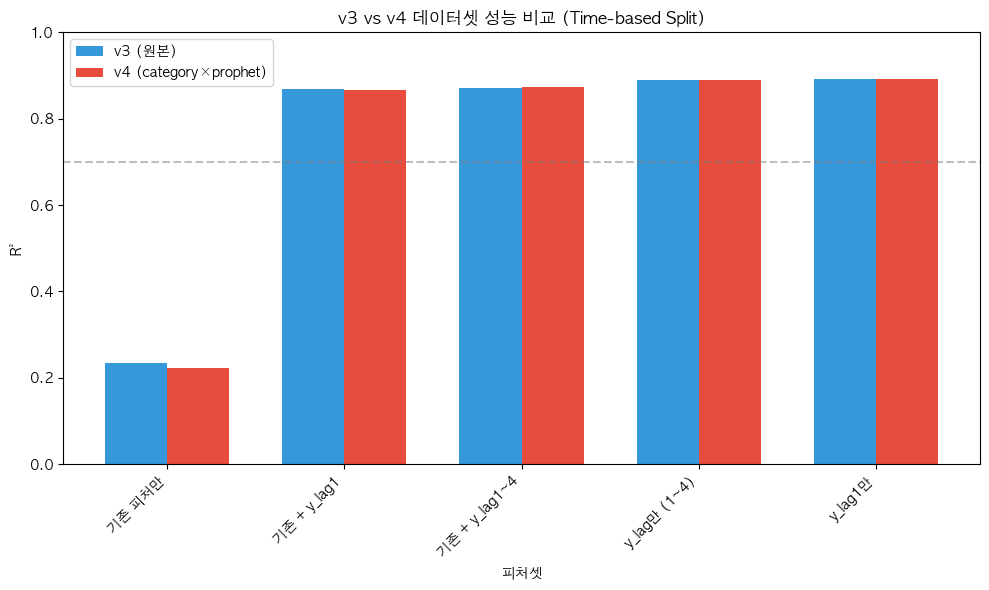

저장: ml_image_v4/v3_vs_v4_comparison.png


In [13]:
# v3 vs v4 시각화
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['v3_r2'], width, label='v3 (원본)', color='#3498db')
bars2 = ax.bar(x + width/2, comparison_df['v4_r2'], width, label='v4 (category×prophet)', color='#e74c3c')

ax.set_xlabel('피처셋')
ax.set_ylabel('R²')
ax.set_title('v3 vs v4 데이터셋 성능 비교 (Time-based Split)')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['features'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(f'{IMG_PATH}/v3_vs_v4_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'저장: {IMG_PATH}/v3_vs_v4_comparison.png')

## 8. 다중 모델 성능 비교

In [14]:
# 회귀 모델 정의
reg_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=5, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
}

needs_scaling = ['Linear Regression', 'Ridge', 'Lasso', 'KNN']

# RobustScaler 적용
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_time), columns=X_train_time.columns, index=X_train_time.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_time), columns=X_test_time.columns, index=X_test_time.index)

# 피처셋
model_feature_sets = {
    '기존 피처만': feature_cols,
    '기존 + y_lag1': feature_cols + ['y_lag1'],
    'y_lag1만': ['y_lag1'],
}

# 모든 조합 테스트
model_results = []

for model_name, model in reg_models.items():
    for feat_name, feat_cols_list in model_feature_sets.items():
        if model_name in needs_scaling:
            X_tr, X_te = X_train_scaled[feat_cols_list], X_test_scaled[feat_cols_list]
        else:
            X_tr, X_te = X_train_time[feat_cols_list], X_test_time[feat_cols_list]
        
        reg = model.__class__(**model.get_params())
        reg.fit(X_tr, y_train_time)
        y_pred = np.maximum(reg.predict(X_te), 0)
        
        model_results.append({
            'model': model_name,
            'features': feat_name,
            'r2': r2_score(y_test_time, y_pred),
            'mae': mean_absolute_error(y_test_time, y_pred),
        })

model_results_df = pd.DataFrame(model_results)
print('[다중 모델 성능 비교 완료]')

[다중 모델 성능 비교 완료]


In [15]:
# 피벗 테이블
pivot_r2 = model_results_df.pivot(index='model', columns='features', values='r2')
pivot_r2 = pivot_r2[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
pivot_r2['개선율(%)'] = ((pivot_r2['기존 + y_lag1'] - pivot_r2['기존 피처만']) / pivot_r2['기존 피처만'].abs() * 100).round(1)
pivot_r2 = pivot_r2.sort_values('기존 + y_lag1', ascending=False)

print('[모델별 R² 점수 비교 (v4, Time-based Split)]')
print(pivot_r2.round(4).to_string())

# 최고 성능
best = model_results_df.loc[model_results_df['r2'].idxmax()]
print(f'\n★ 최고 성능: {best["model"]} + {best["features"]} (R²={best["r2"]:.4f})')

[모델별 R² 점수 비교 (v4, Time-based Split)]
features           기존 피처만  기존 + y_lag1  y_lag1만   개선율(%)
model                                                   
Lasso             -0.0216       0.8897   0.8895   4213.7
Ridge             -0.0238       0.8883   0.8902   3837.9
Linear Regression -0.0232       0.8882   0.8902   3935.1
Gradient Boosting  0.0065       0.8711   0.8928  13263.7
LightGBM           0.2232       0.8675   0.8922    288.7
Random Forest      0.2228       0.8260   0.8930    270.8
KNN               -0.1487       0.6662   0.8883    548.1
XGBoost            0.0838       0.6587   0.8928    685.8

★ 최고 성능: Random Forest + y_lag1만 (R²=0.8930)


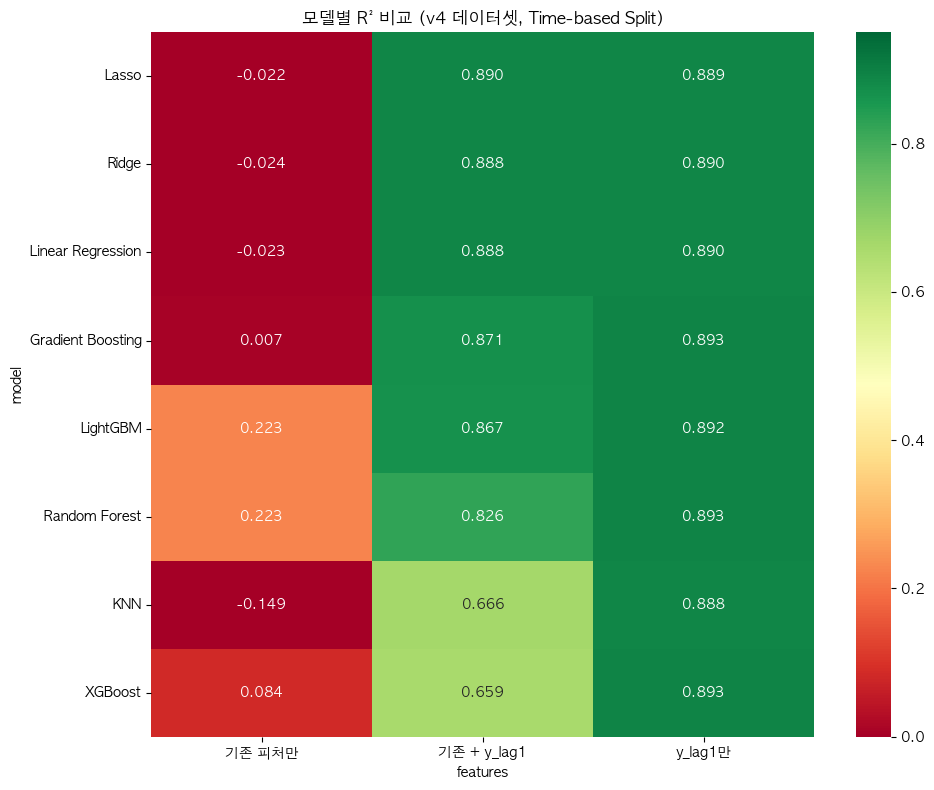

저장: ml_image_v4/model_performance_heatmap.png


In [16]:
# 히트맵 시각화
fig, ax = plt.subplots(figsize=(10, 8))
pivot_r2_plot = pivot_r2[['기존 피처만', '기존 + y_lag1', 'y_lag1만']]
sns.heatmap(pivot_r2_plot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax, vmin=0, vmax=0.95)
ax.set_title('모델별 R² 비교 (v4 데이터셋, Time-based Split)')
plt.tight_layout()
plt.savefig(f'{IMG_PATH}/model_performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print(f'저장: {IMG_PATH}/model_performance_heatmap.png')

## 9. 결론

In [17]:
print('='*70)
print('[v4 데이터셋 분석 결론]')
print('='*70)

print('\n[1. v3 vs v4 비교]')
for _, row in comparison_df.iterrows():
    sign = '+' if row['diff'] > 0 else ''
    print(f'  {row["features"]:<22}: {sign}{row["diff"]:.4f}')

print('\n[2. SHAP 중요도]')
print(f'  y_lag1: {y_lag1_imp/total_imp*100:.1f}%')
print(f'  prophet_forecast (10개): {prophet_imp/total_imp*100:.1f}%')

print('\n[3. 핵심 인사이트]')
print('  - category × prophet_forecast 가중치 적용 후 변화 확인')
print('  - y_lag1은 여전히 가장 강력한 피처')
print('  - prophet_forecast의 상대적 기여도 변화 확인')

[v4 데이터셋 분석 결론]

[1. v3 vs v4 비교]
  기존 피처만                : -0.0123
  기존 + y_lag1           : -0.0009
  기존 + y_lag1~4         : +0.0024
  y_lag만 (1~4)          : 0.0000
  y_lag1만               : 0.0000

[2. SHAP 중요도]
  y_lag1: 67.2%
  prophet_forecast (10개): 8.3%

[3. 핵심 인사이트]
  - category × prophet_forecast 가중치 적용 후 변화 확인
  - y_lag1은 여전히 가장 강력한 피처
  - prophet_forecast의 상대적 기여도 변화 확인


In [18]:
# 저장된 이미지 목록
print('\n[저장된 이미지 파일]')
for f in sorted(os.listdir(IMG_PATH)):
    print(f'  {f}')


[저장된 이미지 파일]
  model_performance_heatmap.png
  shap_feature_importance_bar.png
  v3_vs_v4_comparison.png
